In [1]:
import numpy as np
import matplotlib
from matplotlib import animation
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size':15})

import scipy.linalg as spl
from scipy.interpolate import interp1d
from scipy.integrate import cumtrapz
import xarray as xr

from waveeqn1D import WaveEquation

from utils import *
import nfft
import time

# Solving for the 2D, continously stratified internal wave equation by Fourier transforming in $x$ & time

The pressure perturbation of an internal wave in the Boussinesq approximation in a continuously stratified medium obeys
$$\dfrac{\partial^2}{\partial t^2}\left(\dfrac{\partial^2}{\partial x^2}+\dfrac{\partial^2}{\partial z^2}\right) p + N(z)^2\dfrac{\partial^2 p}{\partial x^2} = 0$$
One can decompose into modes of the form $p(x,z,t) = \Re\left[ \tilde p(z)e^{i(kx-\omega t)} \right]$, with the vertical structure verifying $$\dfrac{\mathrm{d}^2 \tilde p}{\mathrm{d} z^2} + k^2 \left(\dfrac{N(z)^2}{\omega^2}-1\right)\tilde p = 0$$
with Neumann BC at the top and bottom ($\partial p / \partial z=0$ at $z=0$ and $z=-H$). The above equation is recast as an eigenvalue problem of the form
$$\mathbf{A}\tilde p = \lambda \tilde p$$
where $\mathbf{A} = \mathrm{diag}(N(z)^{-2})(\mathbf{D}_2 - k^2 \mathbf{I})$ ($\mathbf{D}_2$ is the discrete second derivative in $z$) and $\lambda = -k^2 \omega^{-2}$.

The full solution reads, in discretized terms, $$ p(x,z,t) = \Re\sum_{n=1}^{N_x} e^{ik_nx}\sum_{l=1}^{N_z}\tilde p_{n,l}(z)\left[C_{n,l}^+e^{i\omega_{n,l}t} + C_{n,l}^-e^{-i\omega_{n,l}t}\right]$$

The $C_{n,l}^{+/-}$ are given by the initial condition. One can show that with initial conditions $p(x,z,0) = p_0(x,z)$ and $\partial_t p(x,z,0) = 0$, $C_{n,l}^+=C_{n,l}^- = C_{n,l}/2$, where $C_{n,l}$ verifies, for each $n$:
$$\sum_{l=1}^{N_z} C_{n,l}\tilde p_{n,l} = \hat p_0(k_n)$$
and $\hat p_0$ is the partial Fourier transform in $x$ of the initial condition $p_0(x,z)$. One can show that $C_{n,l}$ is given by $$C_{n,l}  = \left\langle \tilde q_{n,l}, \hat p_0(k_n,\cdot) \right\rangle$$
where $\tilde q_{n,l}$ is the adjoint eigenvector associated with $\omega_{n,l}$.

In [2]:
# Wave equation class 
class InternalWaveEquation:
    def __init__(self,Lx=10e3,Nx=1000,Lz=1e3,Nz=100,Lt=3600,Nt=60,z0=100,sigma_z=20):
        #x mesh
        self.L_x = Lx #Length of the domain in x [m]
        self.N_x = Nx #Number of points in x
        self.X = np.linspace(0,self.L_x,self.N_x)
        self.dx = self.X[1]-self.X[0] #horizontal discretization
        self.K = 2*np.pi*np.fft.fftfreq(self.N_x,self.dx)
        self.z0 = z0
        self.sigma_z = sigma_z
        
        #z mesh
        self.L_z = Lz #Depth of the domain [m]
        self.N_z = Nz #Number of points in z
        self.Z = np.linspace(0,self.L_z,self.N_z)
        self.dz = self.Z[1]-self.Z[0] #vertical discretization
        
        #Temporal mesh 
        self.L_t = Lt #Length of the integration
        self.N_t = Nt #Number of points in time
        self.T = np.linspace(0,self.L_t,self.N_t)
        self.dt = self.T[1]-self.T[0] #temporal discretization
        
    def I(self,x,z):
        x0=5e3;z0=200.
        zwidth=40
        xwidth=200
        return np.exp(-(z-z0)**2/2/zwidth**2-(x-x0)**2/2/xwidth**2)
        
    def N(self,z):
        return 0.01*z**0
        #return 0.01 + np.exp(-((z-self.z0)**2)/(2*self.sigma_z**2))*0.1
    
    def An(self,k):
        D2 = make_D_fornberg(self.Z,2,npoints=3)
        B = D2 - k**2*np.eye(self.N_z)
        
        #Neumann BCs
        hm1 = np.sqrt(-B[1,1])# B[1,1]=-1/h^2
        B[0]=0. ; B[0,0]  =-3*hm1; B[0,1]  = 4*hm1; B[0,2] =-hm1
        B[-1]=0.; B[-1,-1]= 3*hm1; B[-1,-2]=-4*hm1; B[-1,-3]=hm1
        
        return np.dot(np.diag(1/self.N(self.Z)**2),B)
        
    def eigenmodes(self,k): 
        """Compute the eigenmodes p_tilde_kn and associated eigenvalues. Could be sped up with sparse matrices """
        A = self.An(k)
        
        lambdas,qtildes,ptildes=spl.eig(A,left=True) # The eigenvalues correspond to - k^2 * omega^-2, where omega is the eigenfrequency of each mode
        sortidx = np.argsort(lambdas)
        cutoff=-1 # Throw away non-oscillatory modes
        lambdas = np.real(lambdas[sortidx[:cutoff]])
        qtildes = qtildes[:,sortidx[:cutoff]]
        ptildes = ptildes[:,sortidx[:cutoff]]
        
        #Normalize adjoint eigenvectors
        qtildes = qtildes/np.diagonal(np.dot(qtildes.transpose().conj(),ptildes))[None,:].conj()
        
        return (lambdas,
                np.abs(k)/np.sqrt(-lambdas), # Vector of size N_z-1
                qtildes,                     # Matrix of shape (N_z,N_z-1)
                ptildes,
               ) 
        
    def set_all_eigenmodes(self):
        self.qtildes = np.zeros((self.N_x,self.N_z-1,self.N_z)) # Dimensions: k,n,z
        self.ptildes = np.zeros((self.N_x,self.N_z-1,self.N_z)) # Dimensions: k,n,z
        self.omegas  = np.zeros((self.N_x,self.N_z-1))          # Dimensions: k,n
        self.lambdas = np.zeros((self.N_x,self.N_z-1))          # Dimensions: k,n
        for ik,k in enumerate(self.K):
            lambdas,omegas,qtildes,ptildes = self.eigenmodes(k)
            self.qtildes[ik] = qtildes.transpose()
            self.ptildes[ik] = ptildes.transpose()
            self.omegas[ik]  = omegas
            self.lambdas[ik] = lambdas
    
    def p0hat(self,ik):
        p0 = self.I(self.X[:,None],self.Z[None,:])
        return np.fft.fft(p0,axis=0)[ik]
        
    def integrate(self):
        %time self.set_all_eigenmodes()
        phat = 1j*np.zeros((self.N_x,self.N_z,self.N_t))
        for ik,k in enumerate(self.K):
            if ik == 0:
                continue
            # Get mode coefficients
            Cn = np.dot(self.qtildes[ik],self.p0hat(ik))
            # define evaluation points for the nonuniform inverse fft
            fk = self.omegas[ik]*self.dt/2/np.pi        
            
            # Perform the nonuniform inverse fft in time, grid point by grid point
            for iz in range(self.N_z):
                #phat[ik,iz,0] =  (Cn*self.ptildes[ik,:,iz]).sum()
                phat[ik,iz] =  nfft.nfft_adjoint(-fk, Cn/2*self.ptildes[ik,:,iz]*np.exp(-2*np.pi*1j*(self.N_t//2)*fk), self.N_t)
                phat[ik,iz]+=  nfft.nfft_adjoint( fk, Cn/2*self.ptildes[ik,:,iz]*np.exp( 2*np.pi*1j*(self.N_t//2)*fk), self.N_t)
        
        # Perform the inverse fft in x
        self.p = xr.DataArray(np.real(np.fft.ifft(phat,axis=0)),coords={'x':self.X,'z':self.Z,'time':self.T},dims=['x','z','time'])
        self.p_init = xr.DataArray(self.I(self.X[:,None],self.Z[None,:]),coords={'x':self.X,'z':self.Z},dims=['x','z'])
        

In [3]:
iwave = InternalWaveEquation(Lt=3000,Nt=100,Nx=500,Nz=80)

In [4]:
%time iwave.integrate()

CPU times: user 10.3 s, sys: 824 ms, total: 11.1 s
Wall time: 4.02 s
CPU times: user 2min 46s, sys: 12.5 s, total: 2min 58s
Wall time: 1min 21s


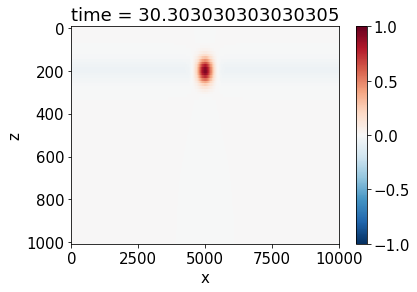

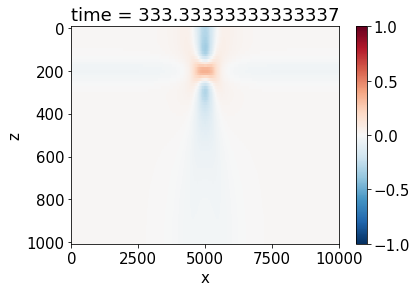

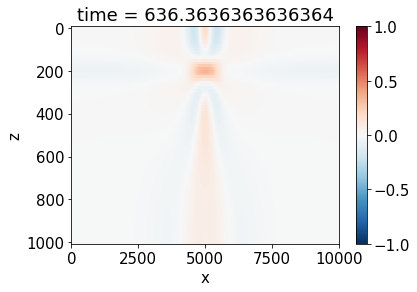

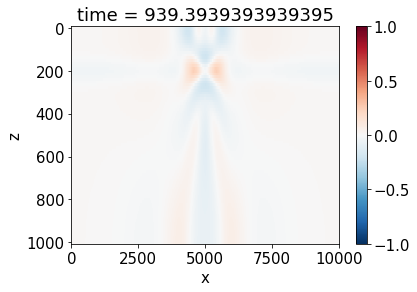

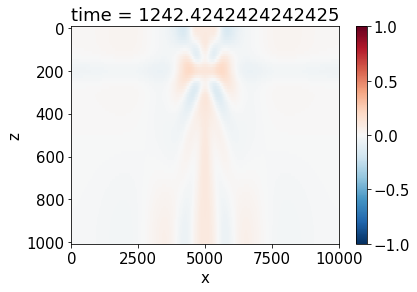

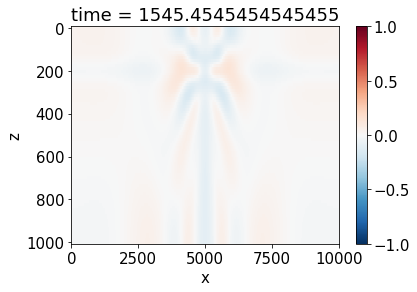

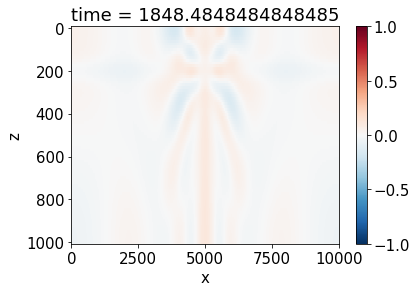

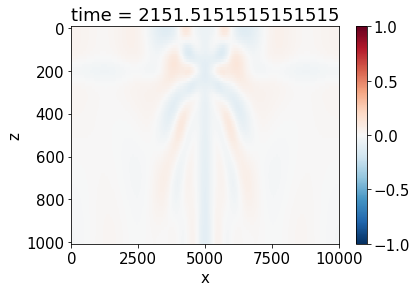

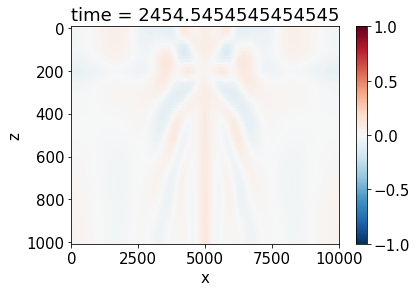

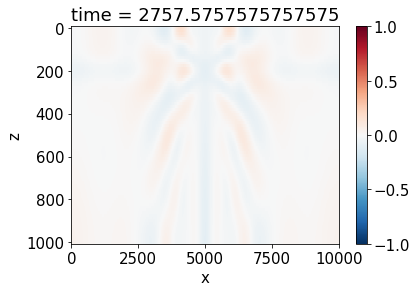

In [5]:
for t in range(1,len(iwave.p.time),10):
    plt.figure()
    iwave.p.isel(time=t).plot(y='z',yincrease=False,vmin=-1,vmax=1,cmap=plt.cm.RdBu_r)

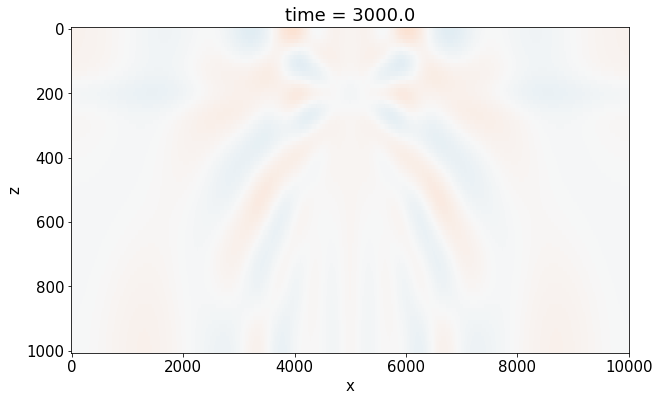

In [6]:
fig,ax = plt.subplots(1,1,figsize=(10,6))

def update(t):
    ax.clear()
    iwave.p.isel(time=t).plot(y='z',yincrease=False,vmin=-1,vmax=1,cmap=plt.cm.RdBu_r, add_colorbar=False)

im_ani = animation.FuncAnimation(fig, update, frames=range(iwave.N_t),interval=100)
im_ani.save("presvid.mp4")